In [1]:
import sys
sys.path.append('../src')

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

from data import ABABProcess, PolynomialProcess, NormalizedSyntheticDataset
from models import FourierEmbedding, PolynomialEmbedding
from utils import set_seed, Trainer

In [2]:
class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, hidden_dim=[1, 32, 2], prospective=False, embedding_type='fourier', tdim=10):
        super(MLP, self).__init__()
        self.prospective = prospective
        
        if prospective:
            if embedding_type == 'fourier':
                self.embedding = FourierEmbedding(tdim)
            elif embedding_type == 'polynomial':
                self.embedding = PolynomialEmbedding(tdim)
            else:
                raise ValueError(f"Unknown embedding type: {embedding_type}")

        self.layers = nn.ModuleList()
        for i in range(len(hidden_dim)-1):
            if prospective and i == 0:
                self.layers.append(nn.Linear(hidden_dim[i] + tdim, hidden_dim[i+1]))
            else:
                self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        self.relu = nn.ReLU()

    def forward(self, x, t):
        if self.prospective:
            t = self.embedding(t)
            x = torch.cat([x, t], dim=-1)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers)-1:
                x = self.relu(x)
        return x

In [ ]:
def get_dataloaders(dp, t, seed, normalize_x, normalize_t):
    """obtain the dataloaders"""
    train_dataset = NormalizedSyntheticDataset(dp.data, t, seed, test=False, normalize_x=normalize_x, normalize_t=normalize_t)
    test_dataset = NormalizedSyntheticDataset(dp.data, t, seed, test=True, normalize_x=normalize_x, normalize_t=normalize_t)

    x, y, t = dp.generate_at_time(t, 500, return_tensors=True)
    x = train_dataset.minimax_normalize(x, train_dataset.x_tr) if normalize_x else x
    t = train_dataset.minimax_normalize(t, train_dataset.t_tr) if normalize_t else t
    ttest_dataset = TensorDataset(x, y, t)

    if len(train_dataset) > 32:
        bs = 32
    else:
        bs = 2

    trainloader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader, ttestloader

In [4]:
# data generating args
process = 'ABAB' # or 'ABAB' or 'Linear'
seq_len = 500
num_seeds = 3
num_samples_per_task = 20
period = 20

# model args
hidden_dim = [1, 8, 8, 2]

# training args
num_epochs = 100
lr = 0.01
criterion = nn.CrossEntropyLoss()

# experiment args
t_list = np.arange(50, 450+1, 50) # list of time steps 

In [5]:
if process == 'Linear':
    dp = PolynomialProcess(
        type='linear',
        seq_len=seq_len,
        num_seeds=num_seeds,
        num_samples_per_task=num_samples_per_task
    )
    methods = [
        {"name": "FTL", "is_prospective" : False, "embedding_type" : "None", "tdim" : 0, "normalize_x" : True, "normalize_t" : False},
        {"name": "P-MLP (fourier)", "is_prospective" : True, "embedding_type" : "fourier", "tdim" : 50, "normalize_x" : True, "normalize_t" : False},
        {"name": "P-MLP (polynomial)", "is_prospective" : True, "embedding_type" : "polynomial", "tdim" : 4, "normalize_x" : True, "normalize_t" : True},
    ]
elif process == 'ABAB':
    dp = ABABProcess(
        period=period,
        seq_len=seq_len,
        num_seeds=num_seeds,
        num_samples_per_task=num_samples_per_task
    )
    methods = [
        {"name": "FTL", "is_prospective" : False, "embedding_type" : "None", "tdim" : 0, "normalize_x" : False, "normalize_t" : False},
        {"name": "P-MLP (fourier)", "is_prospective" : True, "embedding_type" : "fourier", "tdim" : 50, "normalize_x" : False, "normalize_t" : False},
        {"name": "P-MLP (polynomial)", "is_prospective" : True, "embedding_type" : "polynomial", "tdim" : 4, "normalize_x" : False, "normalize_t" : True},
    ]
else:
    raise ValueError(f"Unknown process type: {process}")

dp.generate_data()

In [ ]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

instant_risk = {} # store instant risk for each algorithm
prospective_risk = {} # store prospective risk for each algorithm

for method in methods:
    print(f"Method: {method}")
    instant_losses = []
    prospective_losses = []
    for seed in range(num_seeds):
        print(f"seed = {seed}")
        acorn = seed * 1000 + 1996
        set_seed(acorn)

        iloss_list = []
        ploss_list = []
        
        for t in t_list:
            print(f"time t = {t}")

            trainloader, testloader, ttestloader = get_dataloaders(
                dp, t, seed, 
                normalize_x=method["normalize_x"],
                normalize_t=method["normalize_t"],
            )
        
            model = MLP(
                hidden_dim=hidden_dim,
                prospective=method["is_prospective"], 
                embedding_type=method["embedding_type"],
                tdim=method["tdim"]
            )
            model.to(device)

            optimizer = torch.optim.SGD(
                model.parameters(), 
                lr=lr,
                momentum=0.9, 
                nesterov=True,
                weight_decay=0.00001
            )

            trainer = Trainer(model, trainloader, testloader, ttestloader, criterion, optimizer, device, verbose=True)

            if t > 2:
                trainer.train(num_epochs=num_epochs)
                
            ploss, iloss, _ = trainer.evaluate()
            iloss_list.append(iloss)
            ploss_list.append(ploss)
            print(f"instant loss: {iloss:.4f}, prospective loss: {ploss:.4f}")

        instant_losses.append(iloss_list)
        prospective_losses.append(ploss_list)

    instant_risk[method["name"]] = np.stack(instant_losses).mean(axis=0)
    prospective_risk[method["name"]] = np.stack(prospective_losses).mean(axis=0)

In [ ]:
# save the results
import pickle
with open(f"../results/embedding_results_{process}.pkl", "wb") as f:
    pickle.dump({
        "instant_risk": instant_risk,
        "prospective_risk": prospective_risk,
        "t_list": t_list
    }, f)

### Make Figures

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("default")
sns.set(
    context='poster',
    style='ticks',
    font_scale=0.9,
    rc={'axes.grid':True,
        'grid.color':'.9',
        'grid.linewidth':0.75}
)
plt.rcParams.update({'font.size': 16})
from matplotlib.lines import Line2D

import numpy as np
import pickle

In [8]:
def load_results(file):
    with open(file, 'rb') as file:
        results = pickle.load(file)
    return results

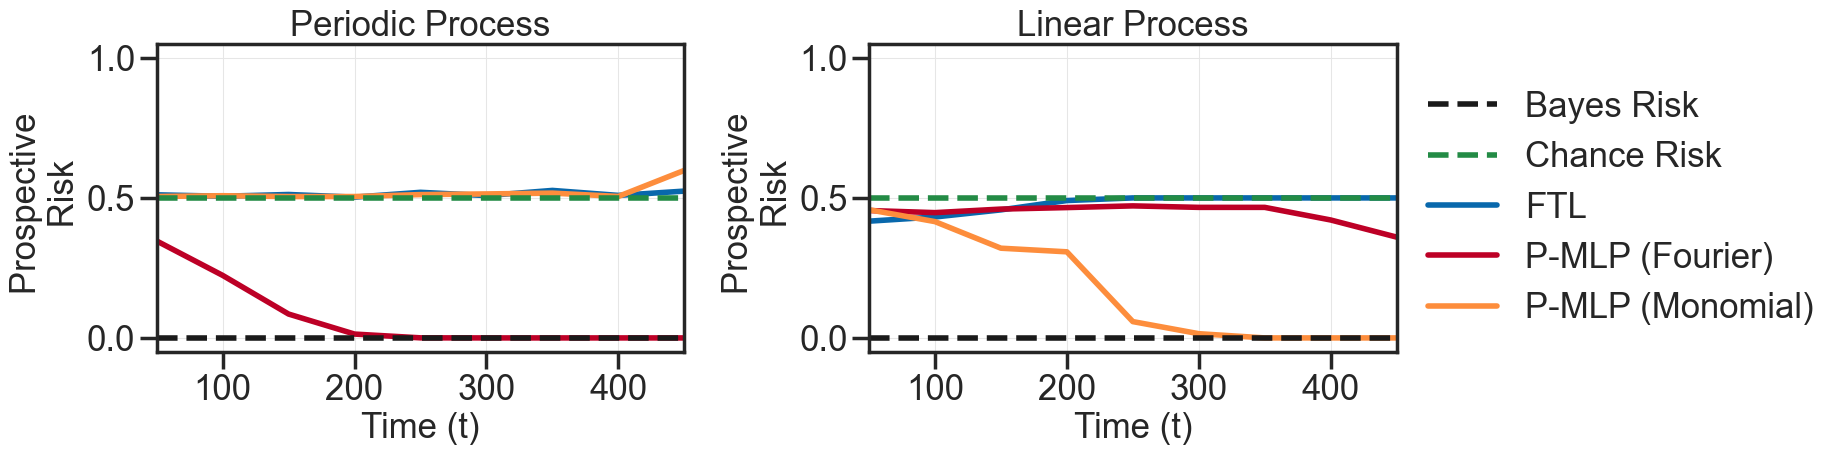

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
colors = ['#0868ac', '#bd0026', '#fd8d3c']

fontsize = 25
lw = 4

methods = ["FTL", "P-MLP (fourier)", "P-MLP (polynomial)"]

ax = axes[0]
results = load_results(f"../results/embedding_results_ABAB.pkl")
t_list = results["t_list"]
prospective_risk = results["prospective_risk"]
for i, method in enumerate(methods):
    ax.plot(t_list, prospective_risk[method], color=colors[i], lw=lw, label=method)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])
ax.set_title("Periodic Process", fontsize=fontsize)

ax = axes[1]
results = load_results(f"../results/embedding_results_Linear.pkl")
t_list = results["t_list"]
prospective_risk = results["prospective_risk"]
for i, method in enumerate(methods):
    ax.plot(t_list, prospective_risk[method], color=colors[i], lw=lw, label=method)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])
ax.set_title("Linear Process", fontsize=fontsize)

for ax in axes:
    ax.plot(t_list, np.zeros_like(t_list), lw=lw, ls='dashed', color='k', label="Bayes Risk")
    ax.plot(t_list, 0.5*np.ones_like(t_list), lw=lw, ls='dashed', color='#238b45', label="Chance Risk")
    ax.set_xlabel("Time (t)", fontsize=fontsize)
    ax.set_ylabel("Prospective \n Risk", fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.grid(visible=True)

plt.subplots_adjust(wspace=0.35)

legend_elements = [
    Line2D([0], [0], color='k', lw=4, ls='dashed', label='Bayes Risk'),
    Line2D([0], [0], color='#238b45', lw=4, ls='dashed', label='Chance Risk'),
    Line2D([0], [0], color='#0868ac', lw=4, label='FTL'),
    Line2D([0], [0], color='#bd0026', lw=4, label='P-MLP (Fourier)'),
    Line2D([0], [0], color='#fd8d3c', lw=4, label='P-MLP (Monomial)'),
]

ax = axes[1]
ax.legend(
    handles=legend_elements, 
    frameon=False, 
    loc='upper left', 
    bbox_to_anchor=(1, 0.95),
    fontsize=fontsize   
)

plt.savefig(f"../figures/3_effect_of_time_embed.pdf", bbox_inches='tight')
plt.show()